# 复现报告3

# 风格轮动：Thompson Sampling 算法应用

本文复现了渤海证券《使用 Thompson Sampling 算法的策略混合模型》。该研报缘起是2017年市值因子失效，于是作者试图寻找一种能够适应市值风格转变的算法。

## 1. 策略复现
研报测试了三种算法：

(1) Greedy Algorithm，GA
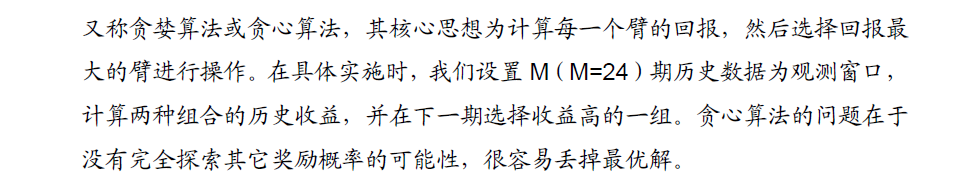

(2) Epsilon-Greedy Algorithm，EGA
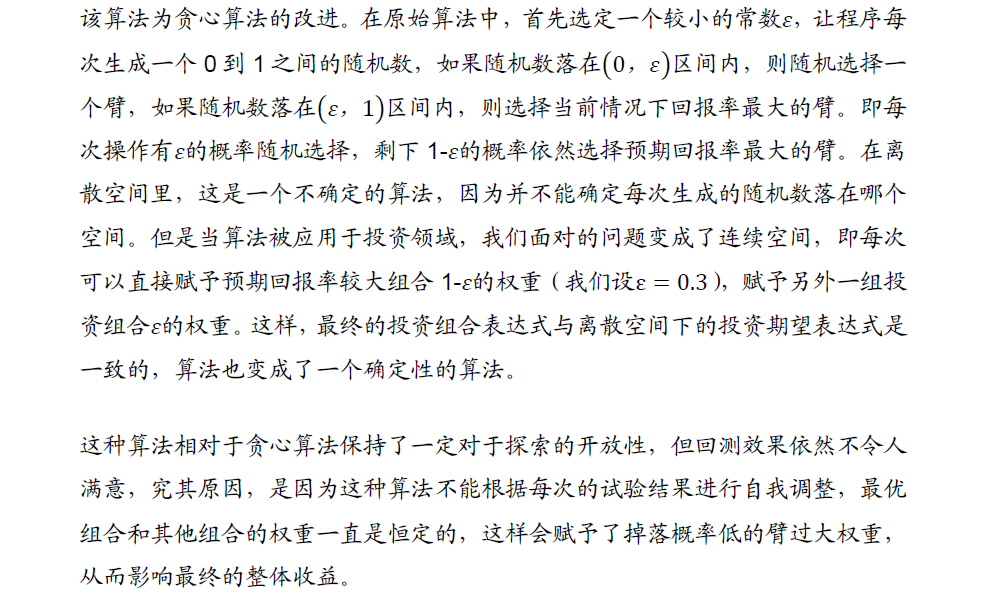

(3) Thompson Sampling Algorithm，TSA
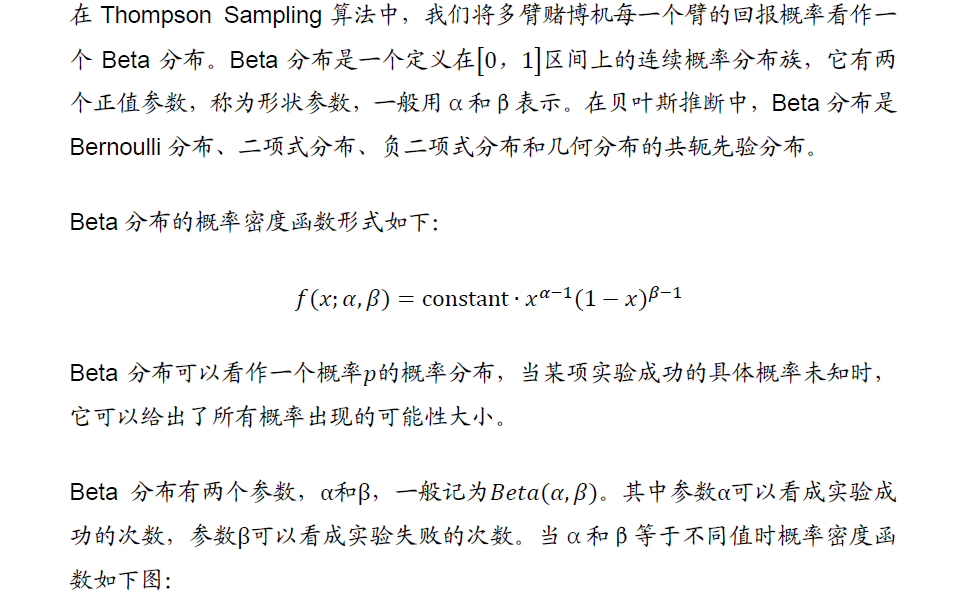

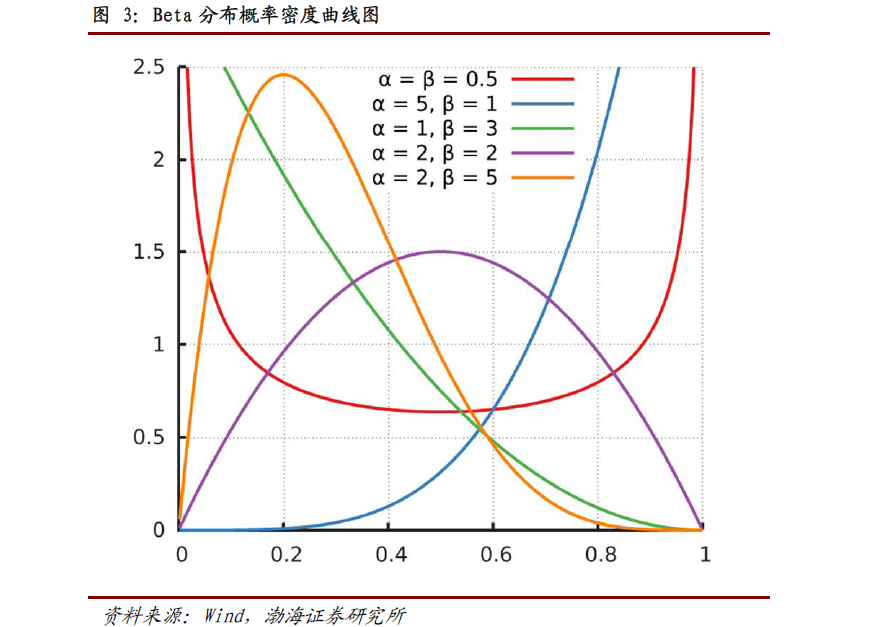

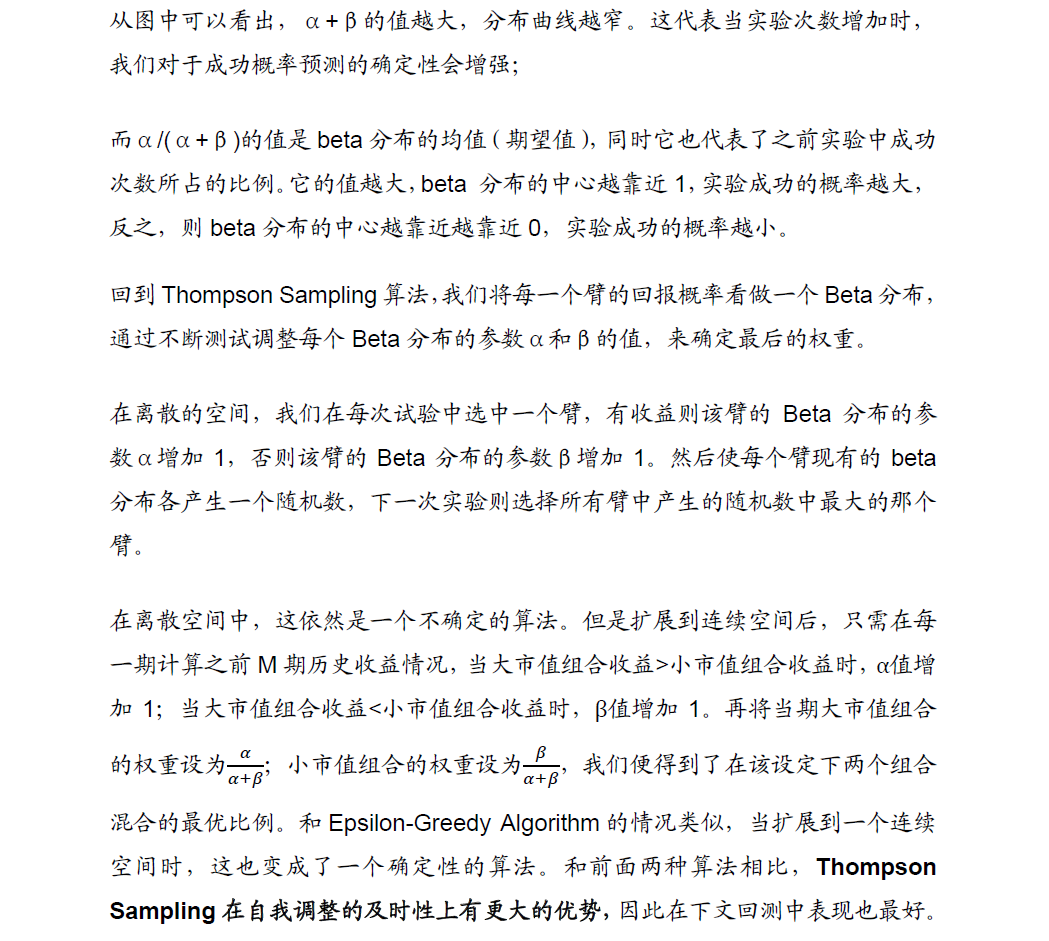

另外还用买入持有（Buy and Hold，BAH）和定期调整资产比例（Constant Rebalanced Portfolios，CRP）作为对照。

研报中通过因子预测收益和行业中性分层构建了大市值组合与小市值组合，但是由于这不是研报的策略重点，因此本文采用中证100指数（SH000903）作为大市值组合，用中证1000指数（SH000852）作为小市值组合。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import atrader as at

In [30]:
#粗糙的ETF类
class roughETF:
    
    def __init__(self, price, fee = 0): 
        self.price = price
        self.n = len(self.price.columns)
        self.fee = fee
        self.value = 1
        self.position = {'old_weight':np.zeros(self.n), 
                         'old_price': np.zeros(self.n), 
                                  'old_value': 0}
        self.record = pd.DataFrame(index = ['value','weight'])
        self.win_times = 0
        self.loss_times = 0
        self.win = 0
        self.loss = 0
        
    def pos_open(self, day, weight):
        new_weight = np.array(weight)
        if ~(self.position['old_weight'] == new_weight).all():
            self.pos_close(day)
            self.position['old_weight'] = new_weight
            new_price = self.price.loc[day,:].values
            self.position['old_price'] = new_price
            self.value -= self.value * self.fee #默认全仓
            self.position['old_value'] = self.value
            
    def pos_close(self, day):
        if ~(self.position['old_weight'] == np.zeros(self.n)).all():
            new_price = self.price.loc[day,:].values
            old_price = self.position['old_price']
            old_weight = self.position['old_weight']
            old_value = self.position['old_value']
            ret = np.dot(old_weight, new_price / old_price - 1)
            if ret > 0:
                self.win_times += 1
                self.win += ret
            else:
                self.loss_times += 1
                self.loss += ret
            self.value = old_value * (1 + ret) * (1 - self.fee)
            self.position = {'old_weight':np.zeros(self.n), 
                             'old_price': np.zeros(self.n), 
                                'old_value': 0}
            
    def valuation(self, day):
        if ~(self.position['old_weight'] == np.zeros(self.n)).all():
            new_price = self.price.loc[day,:].values
            old_price = self.position['old_price']
            old_weight = self.position['old_weight']
            old_value = self.position['old_value']
            ret = np.dot(old_weight, new_price / old_price - 1)
            self.value = old_value * (1 + ret) * (1 - self.fee)
        self.record[day] = [self.value, self.position['old_weight']]
        
    def show_record(self,index_close = 0):
        out = self.record.T
        out['return'] = out['value'].pct_change()
        if isinstance(index_close,pd.Series):
            trade_day = out.index.values
            index = index_close.loc[trade_day]
            out['accindex'] = out['return'] - index.pct_change()
            out.loc[trade_day[0],'accindex'] = 0
            out['accNV'] = (out.loc[:,'accindex'] + 1).values.cumprod()
        return out
    
    def analysis(self, index_close = 0, rf = 0): #index_close should be a series
        items = pd.Series(index = [])
        
        value = self.show_record()['value']
        ret = self.show_record()['return']
        n = len(value) - 1
        ann_ret = (value[-1] / value[0])**(252 / n) - 1
        items['Annualized return'] = ann_ret
        
        ann_std = 252**0.5 * ret.std()
        items['Annualized volatility'] = ann_std
        
        
        items['Sharpe ratio'] = (ann_ret - rf) / ann_std
        
        #计算最大回撤
        mdd = 0
        for i in range(n):
            new_mdd = (1 - value[i:] / value[i]).max()
            if new_mdd > mdd:
                mdd = new_mdd
        items['Max draw down'] = max(0,mdd)

        if self.win_times + self.loss_times > 0:
            #计算胜率
            items['Win times'] = self.win_times
            items['Loss times'] = self.loss_times
            items['Winning rate'] = self.win_times / (self.loss_times + self.win_times)
        
            #计算盈亏比
            avg_profit = self.win / self.win_times
            items['Avg. profit'] =  avg_profit
            avg_loss = - self.loss / self.loss_times
            items['Avg. loss'] = avg_loss
            items['Profit loss ratio'] = avg_profit /  avg_loss
        
        if isinstance(index_close,pd.Series):
            trade_days = value.index.values
            idx_close = index_close[trade_days]
            ann_idx_ret = (idx_close[-1] / idx_close[0])**(252 / n) - 1
            items['Annualized return of Index'] = ann_idx_ret
            
            idx_ret = idx_close.pct_change()
            cov = pd.DataFrame([ret,idx_ret]).T.cov().iloc[0,1]
            var = idx_ret.var()
            beta = cov / var
            y_mean = ret.mean()
            x_mean = idx_ret.mean()
            alpha = y_mean - beta * x_mean
            items['Annualized Alpha'] = (alpha + 1)**252 - 1
            items['Beta'] = beta
            
            TD = ret - idx_ret
            annTE = (252**0.5*TD.std())
            items['Annualized TE'] = annTE
            items['IR'] = (ann_ret - ann_idx_ret)/ annTE
            
        return items

In [172]:
def TSAlg(target_list = ['sse.000903','sse.000852'], 
              begin_date = '2010-05-31',
              end_date = '2020-06-30',
              fre = 'month', 
              M = 24, 
              fee = 0):

    date_day = at.get_kdata(target_list = target_list,
                        frequency = 'day', 
                        fre_num = 1,
                        begin_date = begin_date, 
                        end_date = end_date,
                        fq = 1,
                        fill_up = True, 
                        df = True,
                        sort_by_date = False)
    date_day['time'] = date_day['time'].apply(lambda x:str(x)[:10])
    price_day = date_day.pivot_table(index = 'time', columns = 'code', values = 'close')
    
    period_day = at.get_trading_time(target_list = target_list[0], 
                                    frequency = fre, 
                                    fre_num = 1, 
                                    begin_date = begin_date, 
                                    end_date = end_date)
    period_day['time'] = period_day['time'].apply(lambda x:str(x)[:10])
    period_day = period_day['time'].values
    
    target_list = list(price_day.columns.values)
    trade_list = ['TSA','BAH','CRP','GA','EGA'] + target_list
    traders = {x:roughETF(price_day,fee) for x in trade_list}
    
    n = len(target_list)
    
    weight = {}
    weight['TSA'] = np.zeros(n)
    weight['BAH'] = np.ones(n)/n
    weight['CRP'] = np.ones(n)/n
    weight['GA'] = np.zeros(n)
    weight['EGA'] = np.zeros(n)
    cnt_x = 0
    for x in target_list:
        weight[x] = np.zeros(n)
        weight[x][cnt_x] = 1
        cnt_x += 1
        
    onetime = {'BAH':0}
    for x in target_list:
        onetime[x] = 0
        
    ifopen = 0
    cnt = -1
    day_list = []

    for day in price_day.index:
        
        if day in period_day:
            cnt += 1
            day_list.append(day)
        
        if cnt >= M:
            if ifopen > 0:
                for k in traders:
                    if k not in ['BAH']+target_list:
                        traders[k].pos_close(day)
                        traders[k].pos_open(day, weight[k])
                    elif onetime[k] == 0:
                        traders[k].pos_open(day, weight[k])
                        onetime[k] = 1 
                ifopen = 0
            for k in traders:
                traders[k].valuation(day)
            
        if day in period_day and cnt >= M:
            if ifopen > 0:
                for k in traders:
                    if k not in ['BAH']+target_list:
                        traders[k].pos_close(day)
                        traders[k].pos_open(day, weight[k])
                    elif onetime[k] == 0:
                        traders[k].pos_open(day, weight[k])
                        onetime[k] = 1 
                ifopen = 0
                
            beta_a = np.ones(n)
            beta_b = np.ones(n)
            for i in range(M):
                start_price = price_day.loc[day_list[cnt - M + i],:].values
                end_price = price_day.loc[day_list[cnt - M + i + 1],:].values
                period_return = end_price / start_price
                max_return = max(period_return)
                beta_a[period_return == max_return] += 1
                beta_b[period_return < max_return] += 1
            weight_TS = beta_a / (beta_a + beta_b)
            weight['TSA'] = weight_TS / sum(weight_TS)
                
            GAstart_price = price_day.loc[day_list[cnt - M],:].values
            GAend_price = price_day.loc[day_list[cnt],:].values
            GAreturn = GAend_price / GAstart_price
            weight['GA'] = np.zeros(n)
            weight['GA'][GAreturn == max(GAreturn)] += 1
                
            weight['EGA'] = np.zeros(n)
            weight['EGA'][GAreturn == max(GAreturn)] += 0.7
            weight['EGA'][GAreturn < max(GAreturn)] += 0.3 / (n-1)
                
            ifopen = 1
    
    trade_day = traders['TSA'].show_record().index
    
    CSI300 = at.get_kdata(target_list=['sse.000300'], 
                      frequency='day', 
                      fre_num=1, 
                      begin_date = begin_date, 
                      end_date = end_date,
                      fq = 1, 
                      fill_up = True, 
                      df = True, 
                      sort_by_date = False)
    CSI300['time'] = CSI300['time'].apply(lambda x:str(x)[:10])
    CSI300 = CSI300.set_index('time').loc[trade_day,'close']
            
    nv = pd.concat([traders[x].show_record()['value'] for x in trade_list],axis = 1)
    nv.columns = trade_list
    
    accnv = pd.concat([traders[x].show_record(CSI300)['accNV'] for x in trade_list], axis = 1)
    accnv.columns = trade_list
    anlys = pd.DataFrame({x:traders[x].analysis(CSI300) for x in trade_list}
                        ).loc[traders['TSA'].analysis(CSI300).index]
    
    return nv,accnv, anlys

## 2. 回测复现

首先进行大小市值组合的回测。研报的回测区间为2010-2018，本文延长到2020-06，如果TS算法有效，那么其优势在近期会更加明显。

研报分别在沪深300成分股和中证500成分股中构建大小市值组合，因此分别与沪深300和中证500做比较。本文只用两个指数代表大小市值组合，所以只与沪深300做比较。

In [173]:
rep1_nv, rep1_accnv, rep1_anlys = TSAlg()

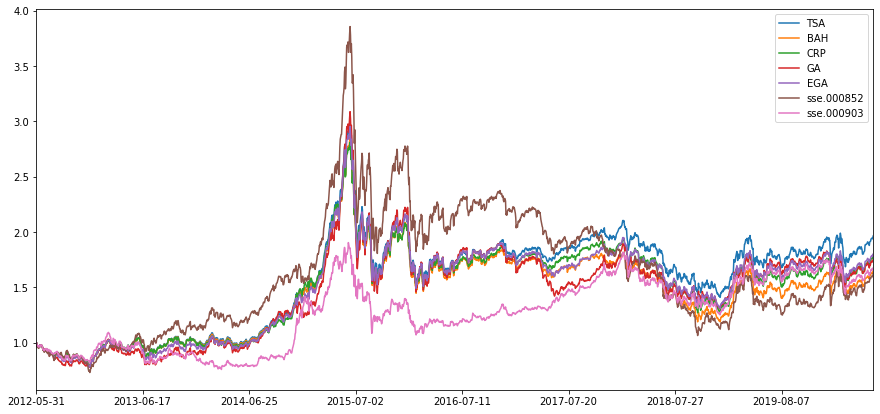

In [174]:
rep1_nv.plot(figsize = (15,7))
plt.show()

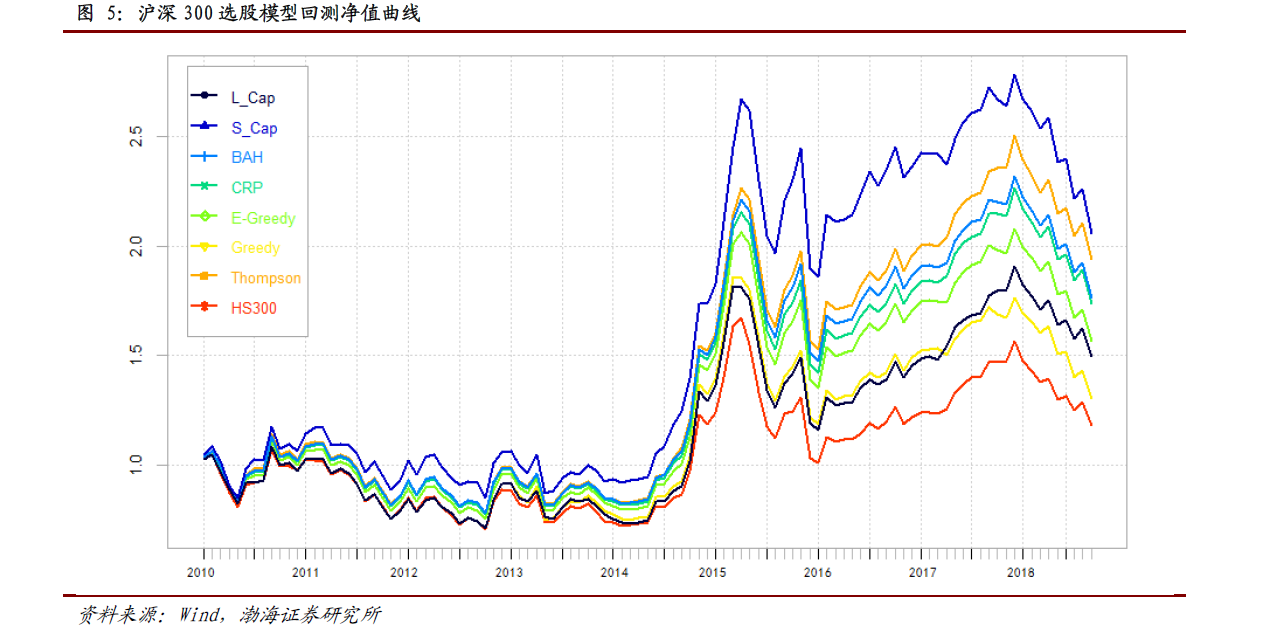

从图形中可以看到，虽然大小市值组合的走势与研报有明显不同，但是TS算法依然体现出了优势。尤其是在2017年左右，小市值组合有大幅度的回撤，市场风格发生巨大转变之后，TS算法组合一跃而上，最终获得最高的累积收益。

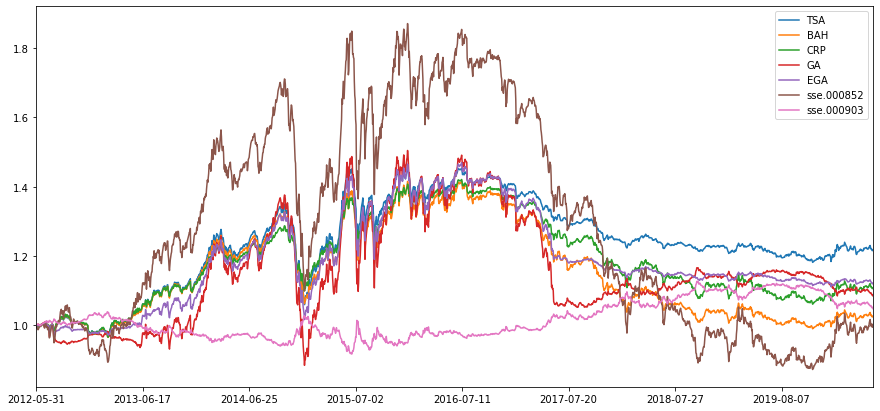

In [175]:
rep1_accnv.plot(figsize = (15,7))
plt.show()

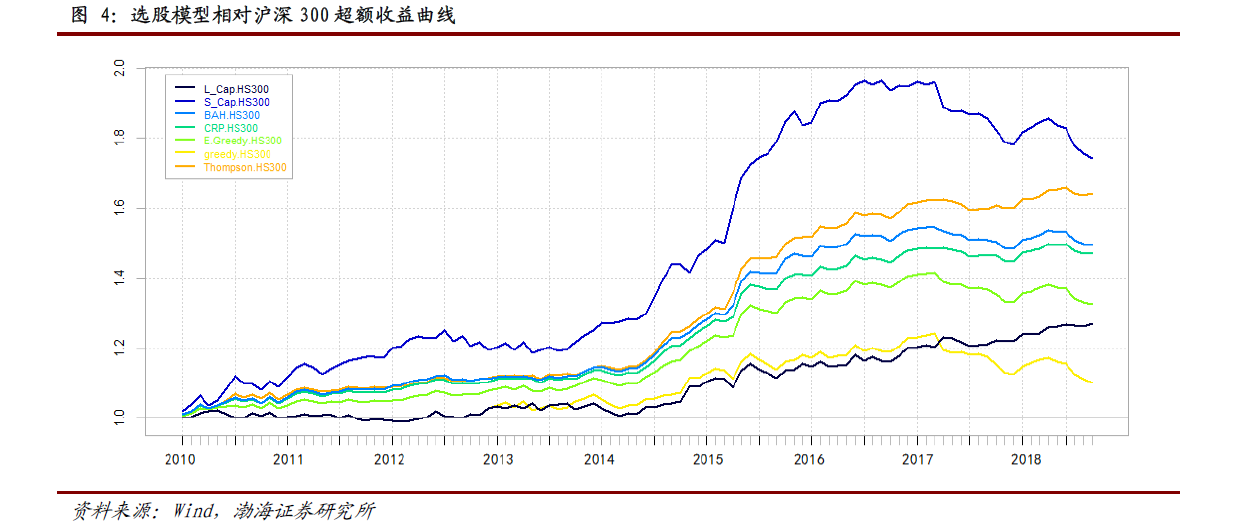

超额收益曲线也很明显地体现出TS算法在风格转换中的优势。

In [176]:
rep1_anlys

,TSA,BAH,CRP,GA,EGA,sse.000852,sse.000903
Annualized return,0.09042,0.06626,0.07687,0.07416,0.07840,0.06413,0.06837
Annualized volatility,0.23582,0.24066,0.23457,0.27022,0.24308,0.28540,0.23278
Sharpe ratio,0.38344,0.27534,0.32770,0.27446,0.32254,0.22469,0.29371
Max draw down,0.52842,0.58339,0.54753,0.57626,0.55571,0.72349,0.43745
Win times,58.00000,NaN,55.00000,59.00000,57.00000,NaN,NaN
Loss times,38.00000,NaN,41.00000,37.00000,39.00000,NaN,NaN
Winning rate,0.60417,NaN,0.57292,0.61458,0.59375,NaN,NaN
Avg. profit,0.05371,NaN,0.05528,0.05944,0.05570,NaN,NaN
Avg. loss,0.05818,NaN,0.05465,0.07095,0.06007,NaN,NaN
Profit loss ratio,0.92314,NaN,1.01153,0.83768,0.92736,NaN,NaN


从回测统计的数据看，TS算法取得最高的夏普比率和年化Alpha。

研报在最后还测试了沪深300等权组合与中证国债指数的配置。本文采用300等权指数（SH000984）和国债指数（SH000012）作为相应标的。

研报提到了取60为移动窗口，但是并未说明调仓频率。本文尝试了每日、每周和每月三种调仓频率。

In [177]:
rep2_nv, rep2_accnv, rep2_anlys = TSAlg(target_list = ['sse.000984','sse.000012'], 
                                        begin_date = '2013-12-31',
                                        end_date = '2020-06-30',
                                          fre = 'day', 
                                          M = 60)

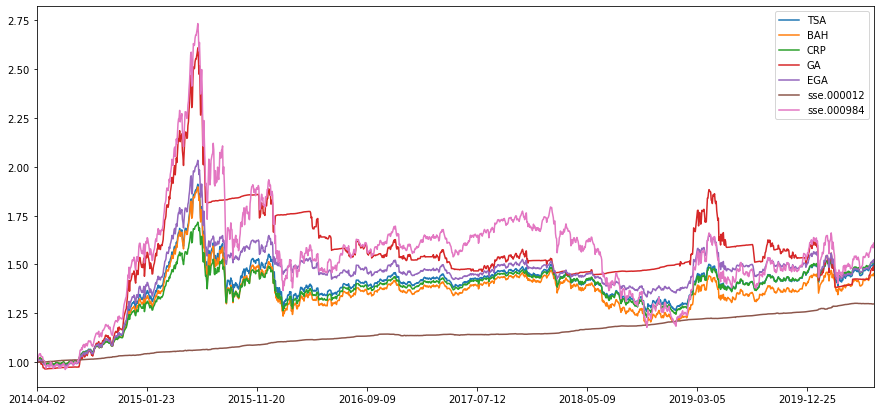

In [178]:
rep2_nv.plot(figsize = (15,7))
plt.show()

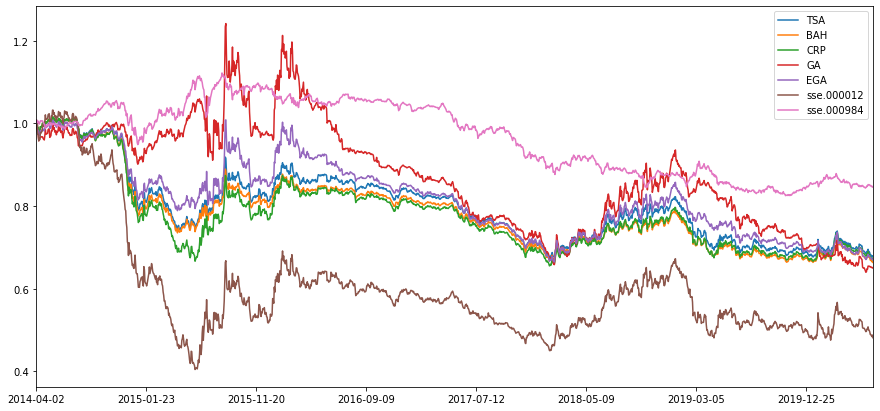

In [179]:
rep2_accnv.plot(figsize = (15,7))
plt.show()

In [180]:
rep2_anlys

,TSA,BAH,CRP,GA,EGA,sse.000012,sse.000984
Annualized return,0.06995,0.06392,0.07152,0.06846,0.07237,0.04413,0.08201
Annualized volatility,0.14064,0.15103,0.12604,0.17051,0.13169,0.00657,0.25207
Sharpe ratio,0.49741,0.42321,0.56743,0.40149,0.54954,6.72075,0.32534
Max draw down,0.34126,0.37607,0.28359,0.47010,0.34418,0.00827,0.56902
Win times,823.00000,NaN,824.00000,997.00000,826.00000,NaN,NaN
Loss times,697.00000,NaN,696.00000,523.00000,694.00000,NaN,NaN
Winning rate,0.54145,NaN,0.54211,0.65592,0.54342,NaN,NaN
Avg. profit,0.00550,NaN,0.00513,0.00416,0.00503,NaN,NaN
Avg. loss,0.00583,NaN,0.00540,0.00699,0.00530,NaN,NaN
Profit loss ratio,0.94454,NaN,0.94918,0.59464,0.94859,NaN,NaN


In [185]:
rep3_nv, rep3_accnv, rep3_anlys = TSAlg(target_list = ['sse.000984','sse.000012'], 
                                        begin_date = '2013-12-31',
                                        end_date = '2020-06-30',
                                          fre = 'week', 
                                          M = 12)

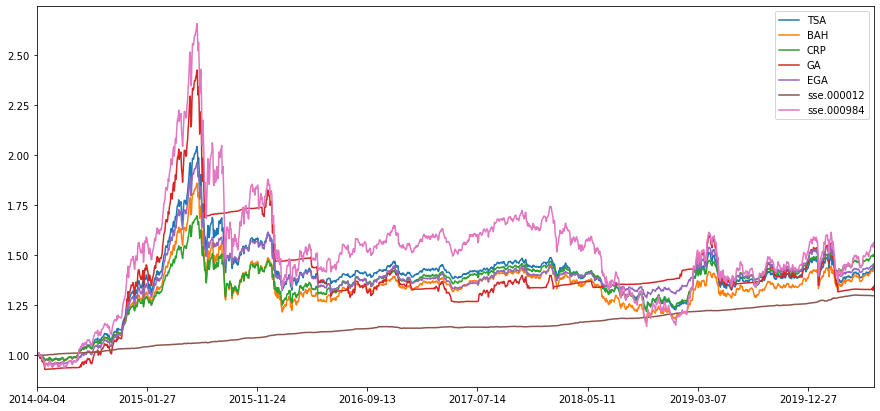

In [186]:
rep3_nv.plot(figsize = (15,7))
plt.show()

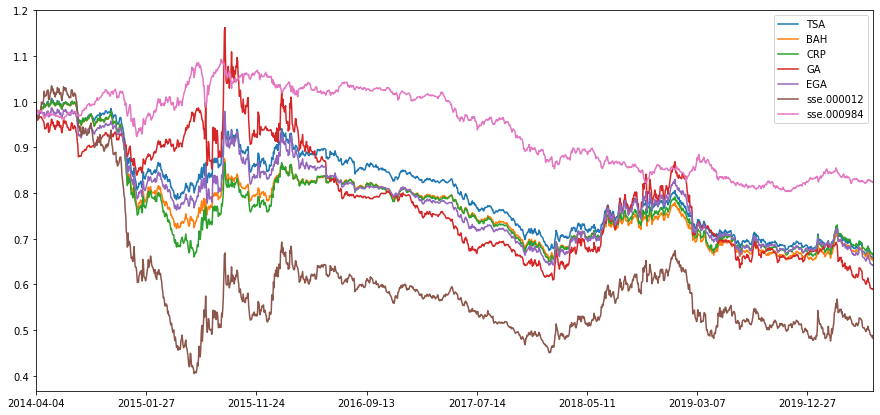

In [187]:
rep3_accnv.plot(figsize = (15,7))
plt.show()

In [188]:
rep3_anlys

,TSA,BAH,CRP,GA,EGA,sse.000012,sse.000984
Annualized return,0.06245,0.06128,0.07013,0.05046,0.06451,0.04421,0.07707
Annualized volatility,0.15082,0.14938,0.12530,0.17271,0.13228,0.00655,0.25209
Sharpe ratio,0.41405,0.41025,0.55970,0.29219,0.48771,6.75169,0.30573
Max draw down,0.40286,0.37211,0.28113,0.47813,0.34364,0.00827,0.56902
Win times,164.00000,NaN,165.00000,213.00000,164.00000,NaN,NaN
Loss times,134.00000,NaN,133.00000,85.00000,134.00000,NaN,NaN
Winning rate,0.55034,NaN,0.55369,0.71477,0.55034,NaN,NaN
Avg. profit,0.01509,NaN,0.01343,0.01011,0.01319,NaN,NaN
Avg. loss,0.01521,NaN,0.01324,0.02078,0.01294,NaN,NaN
Profit loss ratio,0.99186,NaN,1.01481,0.48646,1.01883,NaN,NaN


In [181]:
rep4_nv, rep4_accnv, rep4_anlys = TSAlg(target_list = ['sse.000984','sse.000012'], 
                                        begin_date = '2013-12-31',
                                        end_date = '2020-06-30',
                                          fre = 'month', 
                                          M = 3)

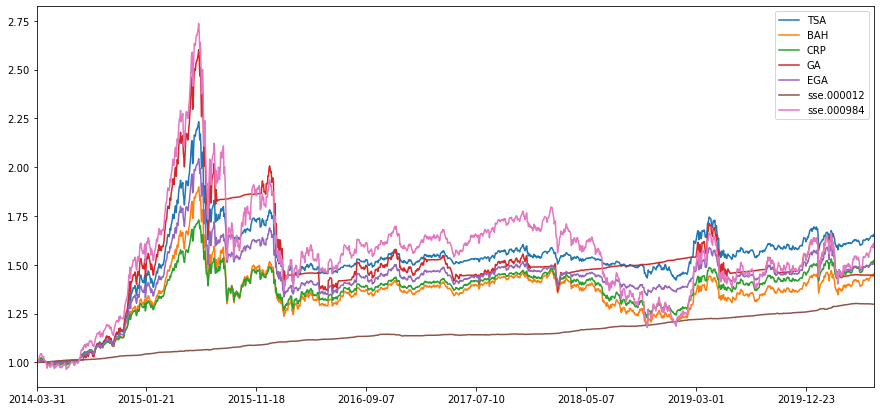

In [182]:
rep4_nv.plot(figsize = (15,7))
plt.show()

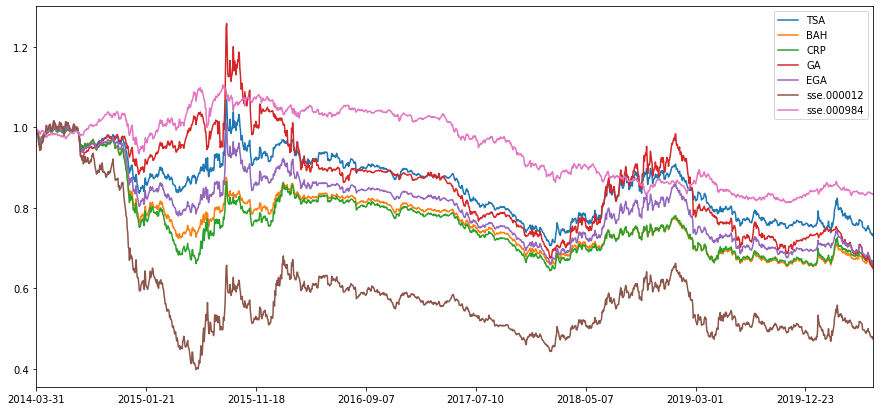

In [183]:
rep4_accnv.plot(figsize = (15,7))
plt.show()

In [184]:
rep4_anlys

,TSA,BAH,CRP,GA,EGA,sse.000012,sse.000984
Annualized return,0.08682,0.06392,0.07182,0.06279,0.07037,0.04409,0.08205
Annualized volatility,0.14612,0.15098,0.12514,0.19333,0.14290,0.00656,0.25193
Sharpe ratio,0.59413,0.42336,0.57394,0.32479,0.49244,6.71837,0.32568
Max draw down,0.37638,0.37618,0.29004,0.47608,0.34673,0.00827,0.56902
Win times,42.00000,NaN,42.00000,53.00000,41.00000,NaN,NaN
Loss times,32.00000,NaN,32.00000,21.00000,33.00000,NaN,NaN
Winning rate,0.56757,NaN,0.56757,0.71622,0.55405,NaN,NaN
Avg. profit,0.03432,NaN,0.02906,0.03018,0.03294,NaN,NaN
Avg. loss,0.02705,NaN,0.02412,0.05164,0.02652,NaN,NaN
Profit loss ratio,1.26903,NaN,1.20452,0.58444,1.24184,NaN,NaN


三种回测结果皆与研报大相径庭，而且仅在月度调仓（同时窗口期为3个月）下，TS有一定的优势，但是仍远不及研报所展示的。另外原来国债指数夏普比率有这么高，强啊。

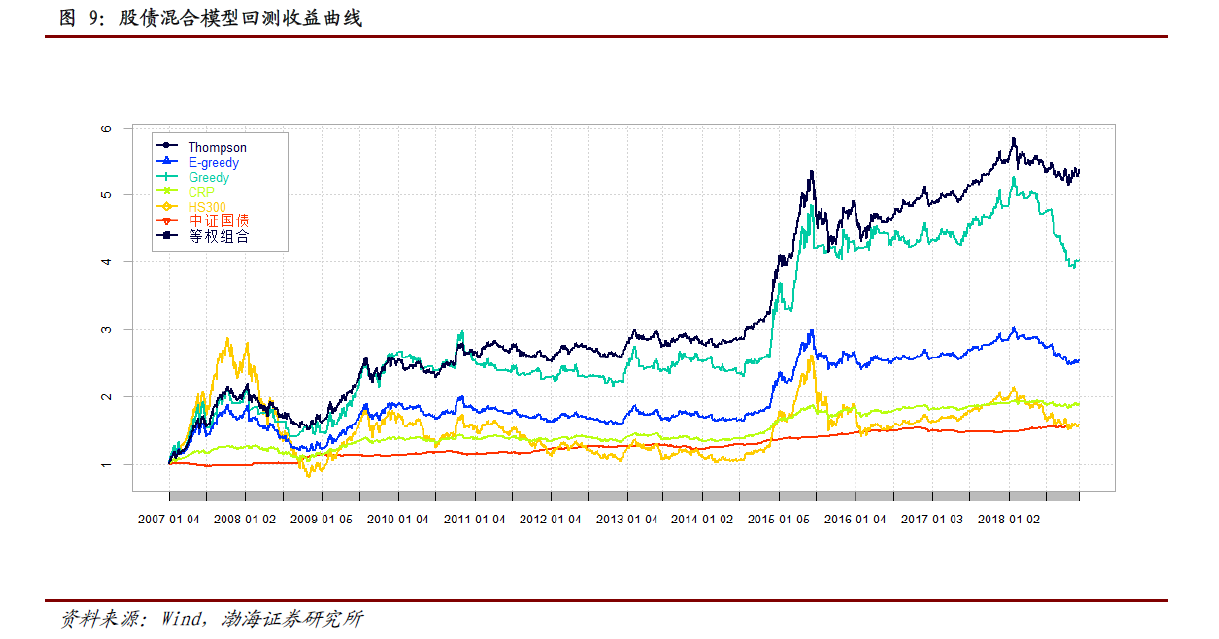

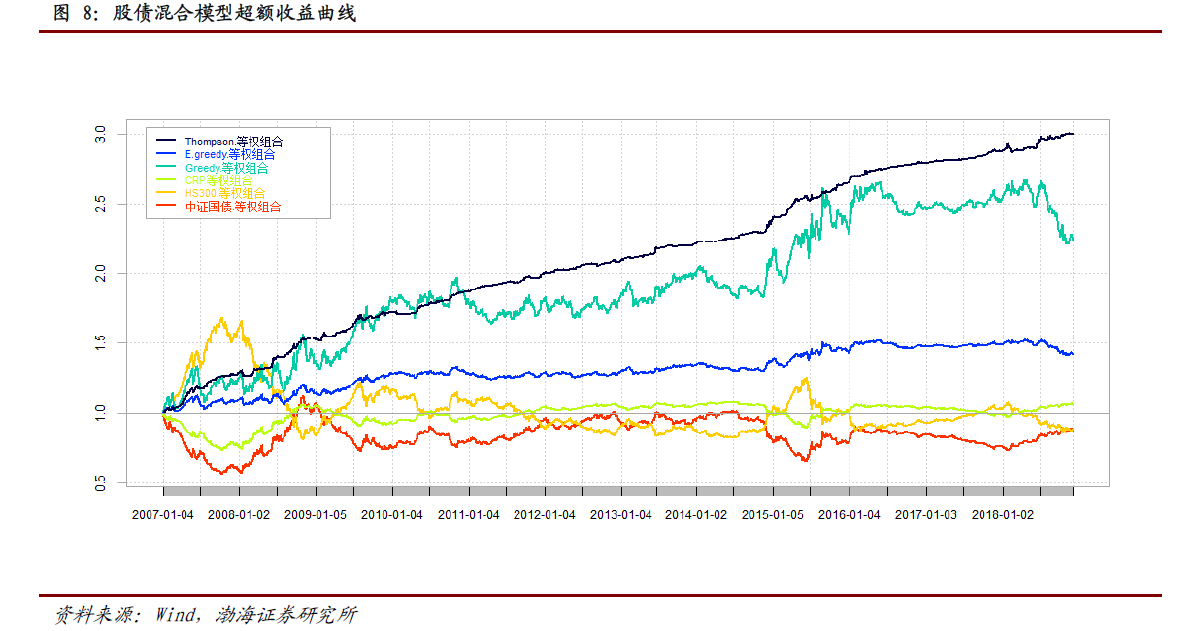

本文最后还尝试了配置四种标的：沪深300指数（SH000300）、中证500指数（SH000905）、国债指数（SH000012）和黄金ETF（SH518880），试图观测包括TS算法在内的资产配置算法能否用于超过两种的标的。

In [201]:
try1_nv, try1_accnv, try1_anlys = TSAlg(target_list = ['sse.000300','sse.000905','sse.000012','sse.518880'], 
                                        begin_date = '2013-12-31',
                                        end_date = '2020-06-30',
                                          fre = 'month', 
                                          M = 5)

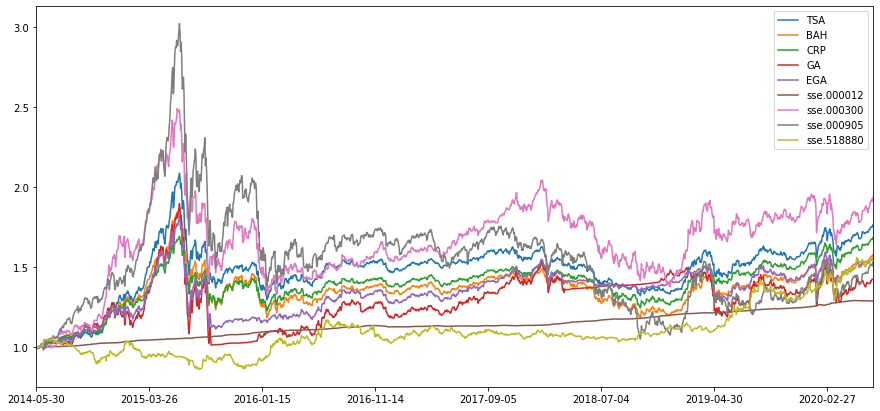

In [202]:
try1_nv.plot(figsize = (15,7))
plt.show()

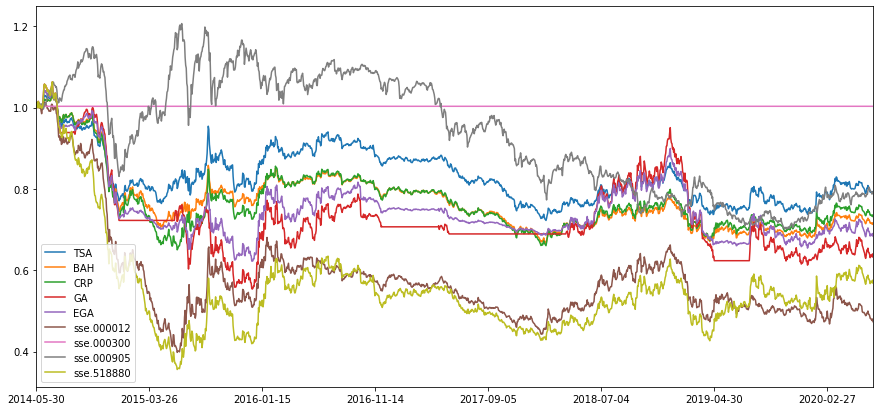

In [203]:
try1_accnv.plot(figsize = (15,7))
plt.show()

In [204]:
try1_anlys

,TSA,BAH,CRP,GA,EGA,sse.000012,sse.000300,sse.000905,sse.518880
Annualized return,0.10132,0.08071,0.09282,0.06209,0.07799,0.04397,0.11896,0.07548,0.07796
Annualized volatility,0.15463,0.15573,0.12797,0.21387,0.16695,0.00654,0.24118,0.28302,0.12897
Sharpe ratio,0.65524,0.51825,0.72532,0.29030,0.46716,6.71798,0.49327,0.26670,0.60447
Max draw down,0.37858,0.36933,0.27509,0.46568,0.38825,0.00827,0.46696,0.65196,0.18809
Win times,42.00000,NaN,44.00000,49.00000,46.00000,NaN,NaN,NaN,NaN
Loss times,30.00000,NaN,28.00000,23.00000,26.00000,NaN,NaN,NaN,NaN
Winning rate,0.58333,NaN,0.61111,0.68056,0.63889,NaN,NaN,NaN,NaN
Avg. profit,0.03837,NaN,0.03014,0.03772,0.03320,NaN,NaN,NaN,NaN
Avg. loss,0.03256,NaN,0.02780,0.05849,0.03870,NaN,NaN,NaN,NaN
Profit loss ratio,1.17868,NaN,1.08421,0.64496,0.85791,NaN,NaN,NaN,NaN


虽然最终TS算法取得所有算法中最高的累积收益，但是在夏普比率和年化Alpha上都没有排在第一位。不过可以看出TS算法、买入持有、定期调仓都有一定的缓冲风险的作用，用这些方法配置多种标的比单独持有沪深300指数有更稳定的收益。